<div style="text-align: center;">
    <h1>Random Forest</h1>
</div>

# Importar Bibliotecas

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from collections import Counter

# Carregar e explorar o dataset

In [7]:
df_data = pd.read_csv('C:/Users/wesle/machine-learning-tecnicas/Dataset/depression_anxiety_data.csv')

In [8]:
# Visualizar as Primeiras Linhas
print(df_data.head(5))

   id  school_year  age  gender        bmi          who_bmi  phq_score  \
0   1            1   19    male  33.333333  Class I Obesity          9   
1   2            1   18    male  19.841270           Normal          8   
2   3            1   19    male  25.102391       Overweight          8   
3   4            1   18  female  23.738662           Normal         19   
4   5            1   18    male  25.617284       Overweight          6   

  depression_severity depressiveness suicidal depression_diagnosis  \
0                Mild          False    False                False   
1                Mild          False    False                False   
2                Mild          False    False                False   
3   Moderately severe           True     True                False   
4                Mild          False    False                False   

  depression_treatment  gad_score anxiety_severity anxiousness  \
0                False         11         Moderate        True   
1 

In [9]:
# Resumo Estatístico
print(df_data.describe())

               id  school_year         age         bmi   phq_score  \
count  783.000000   783.000000  783.000000  783.000000  783.000000   
mean   392.000000     2.277139   20.233716   23.420533    7.123883   
std    226.176922     1.163633    1.767217    4.563630    4.426580   
min      1.000000     1.000000   18.000000    0.000000    0.000000   
25%    196.500000     1.000000   19.000000   20.989420    4.000000   
50%    392.000000     2.000000   20.000000   23.140496    6.000000   
75%    587.500000     3.000000   21.000000   25.519924    9.000000   
max    783.000000     4.000000   31.000000   54.552668   24.000000   

        gad_score  epworth_score  
count  783.000000     775.000000  
mean     6.810983       6.376774  
std      4.727352       3.996443  
min      0.000000       0.000000  
25%      3.000000       3.500000  
50%      6.000000       6.000000  
75%      9.000000       9.000000  
max     21.000000      32.000000  


In [10]:
# Informações do DataFrame
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    783 non-null    int64  
 1   school_year           783 non-null    int64  
 2   age                   783 non-null    int64  
 3   gender                783 non-null    object 
 4   bmi                   783 non-null    float64
 5   who_bmi               783 non-null    object 
 6   phq_score             783 non-null    int64  
 7   depression_severity   779 non-null    object 
 8   depressiveness        780 non-null    object 
 9   suicidal              782 non-null    object 
 10  depression_diagnosis  782 non-null    object 
 11  depression_treatment  779 non-null    object 
 12  gad_score             783 non-null    int64  
 13  anxiety_severity      783 non-null    object 
 14  anxiousness           777 non-null    object 
 15  anxiety_diagnosis     7

In [11]:
# Valores Únicos por Coluna
print(df_data.nunique())

id                      783
school_year               4
age                      13
gender                    2
bmi                     516
who_bmi                   7
phq_score                24
depression_severity       6
depressiveness            2
suicidal                  2
depression_diagnosis      2
depression_treatment      2
gad_score                22
anxiety_severity          5
anxiousness               2
anxiety_diagnosis         2
anxiety_treatment         2
epworth_score            24
sleepiness                2
dtype: int64


In [12]:
# Verificar Dados Ausentes
print(df_data.isnull().sum())

id                      0
school_year             0
age                     0
gender                  0
bmi                     0
who_bmi                 0
phq_score               0
depression_severity     4
depressiveness          3
suicidal                1
depression_diagnosis    1
depression_treatment    4
gad_score               0
anxiety_severity        0
anxiousness             6
anxiety_diagnosis       4
anxiety_treatment       2
epworth_score           8
sleepiness              8
dtype: int64


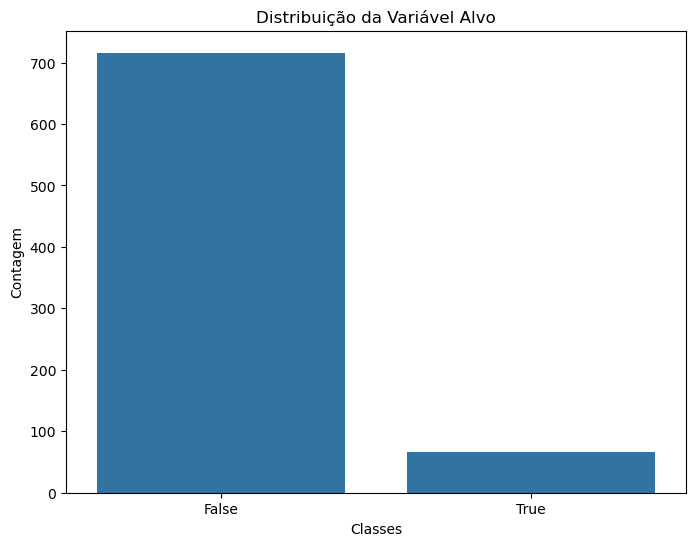

In [13]:
# Distribuição da Variável Alvo
plt.figure(figsize=(8, 6))
sns.countplot(x='depression_diagnosis', data=df_data)
plt.title('Distribuição da Variável Alvo')
plt.xlabel('Classes')
plt.ylabel('Contagem')
plt.show()

# Remoção de missings e transformação de dados categóricos para numéricos

In [15]:
df_data.drop('id', axis = 1, inplace = True)

In [16]:
print('Antes da remoção de missings:\n', df_data['depression_diagnosis'].value_counts())

Antes da remoção de missings:
 depression_diagnosis
False    716
True      66
Name: count, dtype: int64


In [17]:
df_data.dropna(inplace = True) #removendo valores missing, 18 observações foram removidos (783-165)

In [18]:
print('Depois da remoção de missings:\n', df_data['depression_diagnosis'].value_counts())

Depois da remoção de missings:
 depression_diagnosis
False    699
True      66
Name: count, dtype: int64


In [19]:
df_data = df_data[df_data['who_bmi'] != 'Not Availble'] #a partir daqui, not availble não aparece mais, pega todos os elementos menos ele, isso significa que mais 8 observações foram removidas

In [20]:
df_data.shape

(757, 18)

In [21]:
#One-hot-encoding
df = pd.get_dummies(data = df_data, columns = ['who_bmi' , 'gender','depression_severity', 'anxiety_severity'], dtype = int)

#Mudança das características do tipo bool para int
colunas = ['depressiveness','suicidal', 'depression_treatment', 'anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness', 'depression_diagnosis']

for coluna in colunas:
    df[coluna] = df[coluna].astype(int)

In [22]:
df

,school_year,age,bmi,phq_score,depressiveness,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiousness,...,depression_severity_Mild,depression_severity_Moderate,depression_severity_Moderately severe,depression_severity_None-minimal,depression_severity_Severe,depression_severity_none,anxiety_severity_Mild,anxiety_severity_Moderate,anxiety_severity_None-minimal,anxiety_severity_Severe
0,1,19,33.333333,9,0,0,0,0,11,1,...,1,0,0,0,0,0,0,1,0,0
1,1,18,19.841270,8,0,0,0,0,5,0,...,1,0,0,0,0,0,1,0,0,0
2,1,19,25.102391,8,0,0,0,0,6,0,...,1,0,0,0,0,0,1,0,0,0
3,1,18,23.738662,19,1,1,0,0,15,1,...,0,0,1,0,0,0,0,0,0,1
4,1,18,25.617284,6,0,0,0,0,14,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,4,24,21.096191,6,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
779,4,22,25.308642,4,0,0,0,0,6,0,...,0,0,0,1,0,0,1,0,0,0
780,4,22,22.720438,2,0,0,0,0,5,0,...,0,0,0,1,0,0,1,0,0,0
781,4,22,23.033168,17,1,0,0,0,19,1,...,0,0,1,0,0,0,0,0,0,1


In [23]:
df.shape

(757, 32)

# Separando as características (X) e rótulos (y)

In [25]:
X = df.drop(columns=['depression_diagnosis'])
y = df['depression_diagnosis']

# Divisão do dataset em treino e teste

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Padronização das características

In [29]:
scaler = StandardScaler()
#Selecionando apenas as características com diferentes escalas
cols_to_scale = ['age', 'bmi', 'phq_score', 'gad_score', 'epworth_score']

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Cenário 1: All features

## Balanceamento dos dados de treino

In [32]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(f"Distribuição das classes após SMOTE: {Counter(y_train_balanced)}")

Distribuição das classes após SMOTE: Counter({0: 484, 1: 484})


## Treinamento do modelo

In [34]:
random_forest = RandomForestClassifier(n_estimators=100, random_state = 42)

cv_scores = cross_val_score(random_forest, X_train_balanced, y_train_balanced, cv = 10, scoring='accuracy')
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Acurácia média da validação cruzada: 97.21%
Desvio padrão da acurácia: 2.01%


In [35]:
random_forest.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

## Avaliação do modelo

Relatório do modelo

               precision    recall  f1-score   support

           0       0.97      0.98      0.97       209
           1       0.72      0.68      0.70        19

    accuracy                           0.95       228
   macro avg       0.85      0.83      0.84       228
weighted avg       0.95      0.95      0.95       228



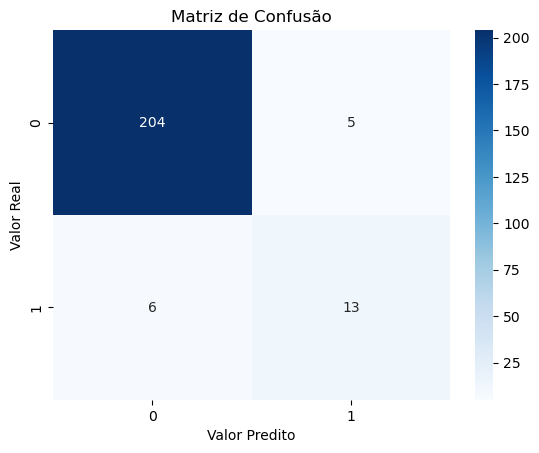

In [37]:
y_pred = random_forest.predict(X_test)

matriz_conf = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real');

print('Relatório do modelo\n\n', classification_report(y_test, y_pred))

# Cenário 2: Selected features

## Seleção de Características

In [40]:
selector = SelectKBest(score_func = f_classif, k=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

view_features = X.columns[selector.get_support()]

print("Características selecionadas:\n", view_features)

Características selecionadas:
 Index(['phq_score', 'depressiveness', 'depression_treatment',
       'anxiety_diagnosis', 'anxiety_treatment'],
      dtype='object')


## Balanceamento dos dados de treino selecionados

In [42]:
X_train_balanced_selected, y_train_balanced_selected = smote.fit_resample(X_train_selected, y_train)

print(f"Distribuição das classes após SMOTE: {Counter(y_train_balanced_selected)}")

Distribuição das classes após SMOTE: Counter({0: 484, 1: 484})


## Treinamento do modelo

In [44]:
cv_scores = cross_val_score(random_forest, X_train_balanced_selected, y_train_balanced_selected, cv = 10, scoring='accuracy')
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Acurácia média da validação cruzada: 94.94%
Desvio padrão da acurácia: 3.59%


In [45]:
random_forest.fit(X_train_balanced_selected, y_train_balanced_selected)

RandomForestClassifier(random_state=42)

## Avaliação do Modelo

Relatório do modelo

               precision    recall  f1-score   support

           0       0.96      0.99      0.97       209
           1       0.79      0.58      0.67        19

    accuracy                           0.95       228
   macro avg       0.87      0.78      0.82       228
weighted avg       0.95      0.95      0.95       228



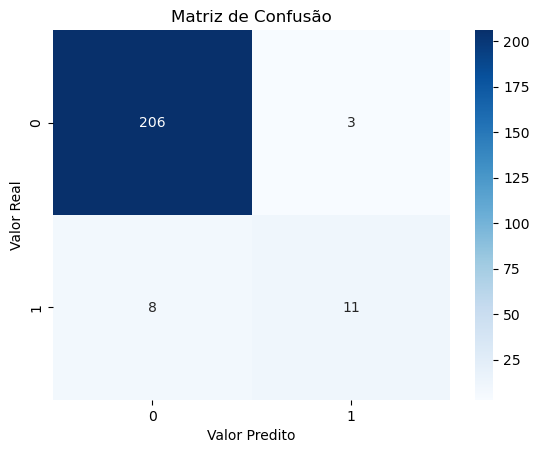

In [47]:
y_pred = random_forest.predict(X_test_selected)

matriz_conf = confusion_matrix(y_test, y_pred)

sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real');

print('Relatório do modelo\n\n', classification_report(y_test, y_pred))